In [1]:
import qiskit

In [2]:
from qiskit import QuantumCircuit

In [4]:
def half_adder(qc):

    #mesuare all qbits 0, 1 and 2
    qc.measure(0,0)
    qc.measure(1,1)
    qc.measure(2,2)

    #apply CNOT on qbits 1 and 2 with qbit 3 as control
    qc.cx(1,3)
    qc.cx(2,3)

    #apply CNOT on qbits 0 and 3 with qbit 4 as control
    qc.cx(0,4)
    qc.cx(3,4)

    #mesuare qbit 4 with contain the result of the sum of the qbits 0, 1 and 2
    qc.measure(4,3)

In [6]:
def carry_out(qc):
    #apply CCNOT on qbits 1 and 2 with qbit 5 as control
    qc.ccx(1,2,5)
    #apply CCNOT on qbits 0 and 3 with qbit 6 as control
    qc.ccx(0,3,6)

    #invert qbits 5 and 6
    qc.x(5)
    qc.x(6)

    #apply CcNOT on qbits 5 and 6 with qbit 7 as control
    qc.ccx(5,6,7)

    #invert qbit 7
    qc.x(7)

    #measure qbit 7 with contain the carry out of the sum of the qbits 0, 1 and 2
    qc.measure(7,4)

In [7]:
#create quantum circuit with 7 qbits and 4 classical bits
qc = QuantumCircuit(8,5, name="full_adder")

#set to 1 all qbits
qc.x(0)
qc.x(1)
qc.x(2)

half_adder(qc)
carry_out(qc)

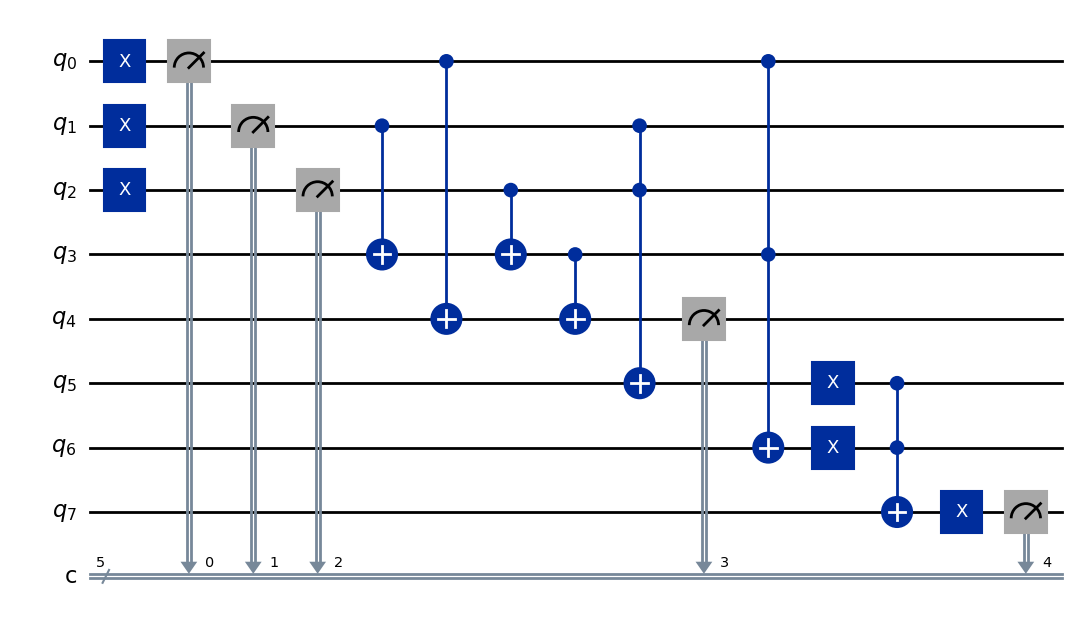

In [8]:
qc.draw(output='mpl',style='iqp')

In [29]:
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
YY = Pauli('YY')
YI = Pauli('YI')
IY = Pauli('IY')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [ZZ, ZI, IZ, YY, YI, IY, XX, XI, IX]

In [32]:
from qiskit_aer.primitives import Estimator

estimator = Estimator()

job = estimator.run([qc]*len(observables), observables)
job.result()

ValueError: The number of qubits of the 0-th circuit (8) does not match the number of qubits of the 0-th observable (2).